# MPC+RL Evaluation Analysis

This notebook provides interactive analysis and visualization of your MPC+RL wind farm control evaluation results.

## Contents
1. **Setup & Data Loading** - Load all evaluation datasets
2. **Quick Overview** - Performance summary across all methods
3. **RL Learning Progress** - Performance vs training steps (learning curves)
4. **Time Series Analysis** - Power, yaw angles, wind conditions over time
5. **Individual Turbine Analysis** - Per-turbine power and yaw angles
6. **Wind Estimation Analysis** - Estimation accuracy and errors
7. **Performance Comparison** - Aggregate metrics and comparisons
8. **Custom Analysis** - Space for your own explorations

## 1. Setup & Data Loading

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("✓ Imports loaded")

✓ Imports loaded


In [2]:
# Helper function to extract 1D time series from xarray DataArrays
def extract_1d_timeseries(data_array):
    """
    Extract 1D time series from a DataArray, properly handling extra dimensions.
    """
    result = data_array
    
    # Select first element of common extra dimensions if they exist
    extra_dims = ['turbbox', 'model_step', 'deterministic']
    for dim in extra_dims:
        if dim in result.dims:
            result = result.isel({dim: 0})
    
    # Squeeze to remove any size-1 dimensions
    result = result.squeeze()
    
    # Get values - should now be 1D
    values = result.values
    
    # If still not 1D, flatten it
    if values.ndim > 1:
        values = values.ravel()
    
    return values

print("✓ Helper functions defined")

✓ Helper functions defined


In [3]:
# Load evaluation datasets
datasets = {}

# Define which datasets to load
eval_files = {
    'Greedy': 'evals/greedy_baseline.nc',
    'Sensor MPC': 'evals/mpc_front_turbine.nc',
    'Simple Est. MPC': 'evals/mpc_simple_estimator.nc',
    'Oracle MPC': 'evals/mpc_oracle.nc',
    'RL+MPC': 'evals/testrun7.nc',  # Change this to your model name
}

# Load each dataset
for name, filepath in eval_files.items():
    try:
        datasets[name] = xr.open_dataset(filepath)
        print(f"✓ Loaded {name}: {filepath}")
    except FileNotFoundError:
        print(f"✗ Could not find {name}: {filepath}")

print(f"\n✓ Loaded {len(datasets)} datasets")

✓ Loaded Greedy: evals/greedy_baseline.nc
✓ Loaded Sensor MPC: evals/mpc_front_turbine.nc
✓ Loaded Simple Est. MPC: evals/mpc_simple_estimator.nc
✓ Loaded Oracle MPC: evals/mpc_oracle.nc
✓ Loaded RL+MPC: evals/testrun7.nc

✓ Loaded 5 datasets


In [4]:
# Inspect dataset structure
if datasets:
    first_name = list(datasets.keys())[0]
    ds = datasets[first_name]
    print(f"Dataset structure for '{first_name}':")
    print("\nDimensions:")
    print(ds.dims)
    print("\nCoordinates:")
    print(ds.coords)
    print("\nData variables:")
    print(list(ds.data_vars))

Dataset structure for 'Greedy':

Dimensions:
FrozenMappingWarningOnValuesAccess({'ws': 1, 'wd': 3, 'turb': 3, 'time': 103, 'TI': 1, 'turbbox': 1, 'model_step': 1, 'deterministic': 1})

Coordinates:
Coordinates:
  * ws             (ws) int64 8B 9
  * wd             (wd) int64 24B 265 270 275
  * turb           (turb) int64 24B 0 1 2
  * time           (time) int64 824B 490 500 510 520 530 ... 1480 1490 1500 1510
  * TI             (TI) float64 8B 0.05
  * turbbox        (turbbox) <U6 24B 'Random'
  * model_step     (model_step) int64 8B 0
  * deterministic  (deterministic) bool 1B False

Data variables:
['powerF_a', 'powerT_a', 'yaw_a', 'ws_a', 'reward', 'powerF_b', 'powerT_b', 'yaw_b', 'ws_b', 'pct_inc']


## 2. Quick Overview

In [5]:
# Performance summary table
summary_data = []

# Get greedy power for baseline
greedy_power = datasets['Greedy'].powerF_a.mean().values if 'Greedy' in datasets else None

for name, ds in datasets.items():
    mean_power = ds.powerF_a.mean().values
    pct_inc = ((mean_power - greedy_power) / greedy_power * 100) if greedy_power else 0
    
    summary_data.append({
        'Method': name,
        'Mean Power (MW)': f'{mean_power/1e6:.2f}',
        'Power Increase (%)': f'{pct_inc:.2f}',
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)


PERFORMANCE SUMMARY
         Method Mean Power (MW) Power Increase (%)
         Greedy            6.95               0.00
     Sensor MPC            6.95               0.00
Simple Est. MPC            8.47              21.97
     Oracle MPC            9.27              33.50
         RL+MPC            8.29              19.39


## 3. Time Series Analysis

### 3.1 Select Wind Condition

In [6]:
# Select which wind condition to analyze
# Modify these to explore different conditions
ws_select = 9.0   # Wind speed (m/s)
wd_select = 270.0  # Wind direction (degrees)
ti_select = 0.05   # Turbulence intensity

# For RL+MPC: which training checkpoint to visualize (if multiple available)
# Set to None to use the last/most trained checkpoint
model_step_select = None  # Or specify like: 20000, 40000, etc.

print(f"Selected condition: WS={ws_select} m/s, WD={wd_select}°, TI={ti_select}")

# Check which datasets have this condition
for name, ds in datasets.items():
    has_ws = ws_select in ds.ws.values
    has_wd = wd_select in ds.wd.values
    has_ti = ti_select in ds.TI.values
    if has_ws and has_wd and has_ti:
        print(f"  ✓ {name} has this condition")
        
        # For RL+MPC, show available model steps
        if name == 'RL+MPC' and 'model_step' in ds.dims and len(ds.model_step) > 1:
            print(f"    Available training checkpoints: {ds.model_step.values}")
            if model_step_select is None:
                print(f"    Will use: {ds.model_step.values[-1]} (most trained)")
            else:
                print(f"    Will use: {model_step_select}")
    else:
        print(f"  ✗ {name} missing this condition")

Selected condition: WS=9.0 m/s, WD=270.0°, TI=0.05
  ✓ Greedy has this condition
  ✓ Sensor MPC has this condition
  ✓ Simple Est. MPC has this condition
  ✓ Oracle MPC has this condition
  ✓ RL+MPC has this condition
    Available training checkpoints: [    0 10002 20004 30000 50004]
    Will use: 50004 (most trained)


In [7]:
# Check if RL+MPC dataset has model_step dimension
if 'RL+MPC' in datasets:
    ds_rl = datasets['RL+MPC']
    
    if 'model_step' in ds_rl.dims and len(ds_rl.model_step) > 1:
        print(f"✓ RL+MPC has {len(ds_rl.model_step)} training checkpoints")
        print(f"  Model steps: {ds_rl.model_step.values}")
    else:
        print("⚠ RL+MPC only has single model_step - was it evaluated at multiple checkpoints?")
        print(f"  Model step value: {ds_rl.model_step.values}")
else:
    print("✗ RL+MPC dataset not loaded")

✓ RL+MPC has 5 training checkpoints
  Model steps: [    0 10002 20004 30000 50004]


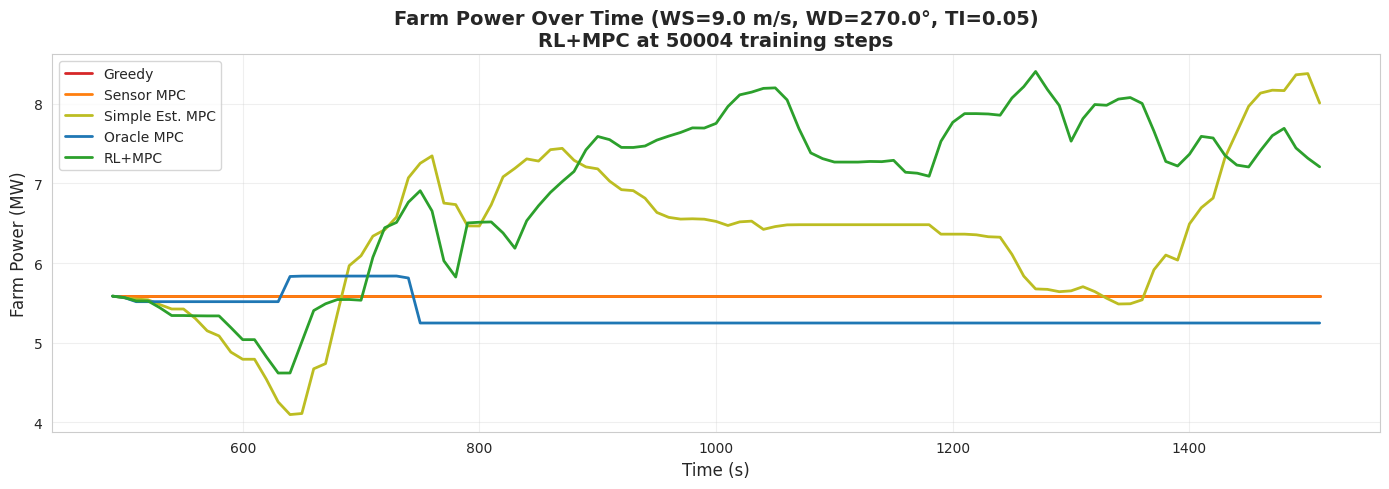

In [8]:
# Plot farm power over time for all methods
fig, ax = plt.subplots(figsize=(14, 5))

colors = {
    'Greedy': '#d62728',
    'Sensor MPC': '#ff7f0e',
    'Simple Est. MPC': '#bcbd22',
    'RL+MPC': '#2ca02c',
    'Oracle MPC': '#1f77b4',
}

for name, ds in datasets.items():
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        
        # For RL+MPC, select specific model_step if multiple available
        if name == 'RL+MPC' and 'model_step' in data_slice.dims and len(data_slice.model_step) > 1:
            if model_step_select is not None:
                data_slice = data_slice.sel(model_step=model_step_select, method='nearest')
            else:
                # Use last (most trained) checkpoint
                data_slice = data_slice.isel(model_step=-1)
        
        power = extract_1d_timeseries(data_slice.powerF_a)
        time = extract_1d_timeseries(data_slice.time)
        
        ax.plot(time, power / 1e6, label=name, color=colors.get(name), linewidth=2)
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Farm Power (MW)', fontsize=12)

# Update title to show model_step if specified
title = f'Farm Power Over Time (WS={ws_select} m/s, WD={wd_select}°, TI={ti_select})'
if 'RL+MPC' in datasets and 'model_step' in datasets['RL+MPC'].dims:
    if model_step_select is not None:
        title += f'\nRL+MPC at {model_step_select} training steps'
    elif len(datasets['RL+MPC'].model_step) > 1:
        title += f'\nRL+MPC at {datasets["RL+MPC"].model_step.values[-1]} training steps'

ax.set_title(title, fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Time Series Analysis

### 3.1 Select Wind Condition

In [9]:
# Select which wind condition to analyze
# Modify these to explore different conditions
ws_select = 9.0   # Wind speed (m/s)
wd_select = 270.0  # Wind direction (degrees)
ti_select = 0.05   # Turbulence intensity

print(f"Selected condition: WS={ws_select} m/s, WD={wd_select}°, TI={ti_select}")

# Check which datasets have this condition
for name, ds in datasets.items():
    has_ws = ws_select in ds.ws.values
    has_wd = wd_select in ds.wd.values
    has_ti = ti_select in ds.TI.values
    if has_ws and has_wd and has_ti:
        print(f"  ✓ {name} has this condition")
    else:
        print(f"  ✗ {name} missing this condition")

Selected condition: WS=9.0 m/s, WD=270.0°, TI=0.05
  ✓ Greedy has this condition
  ✓ Sensor MPC has this condition
  ✓ Simple Est. MPC has this condition
  ✓ Oracle MPC has this condition
  ✓ RL+MPC has this condition


## 4. Individual Turbine Analysis

### 4.1 Per-Turbine Power

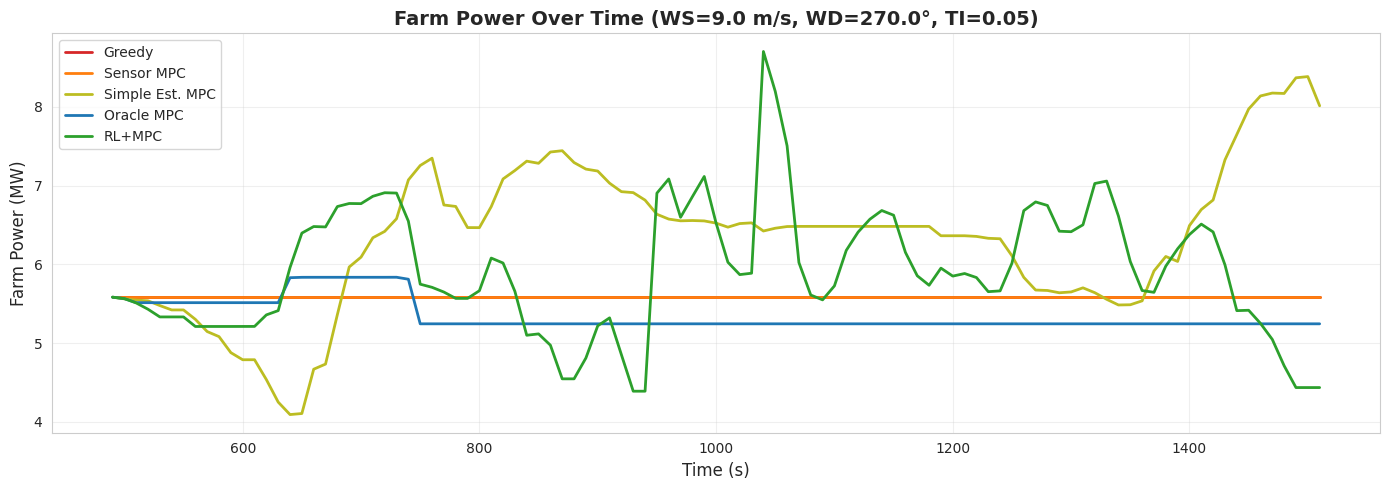

In [10]:
# Plot farm power over time for all methods
fig, ax = plt.subplots(figsize=(14, 5))

colors = {
    'Greedy': '#d62728',
    'Sensor MPC': '#ff7f0e',
    'Simple Est. MPC': '#bcbd22',
    'RL+MPC': '#2ca02c',
    'Oracle MPC': '#1f77b4',
}

for name, ds in datasets.items():
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        power = extract_1d_timeseries(data_slice.powerF_a)
        time = extract_1d_timeseries(data_slice.time)
        
        ax.plot(time, power / 1e6, label=name, color=colors.get(name), linewidth=2)
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Farm Power (MW)', fontsize=12)
ax.set_title(f'Farm Power Over Time (WS={ws_select} m/s, WD={wd_select}°, TI={ti_select})', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Power Increase vs Greedy Baseline

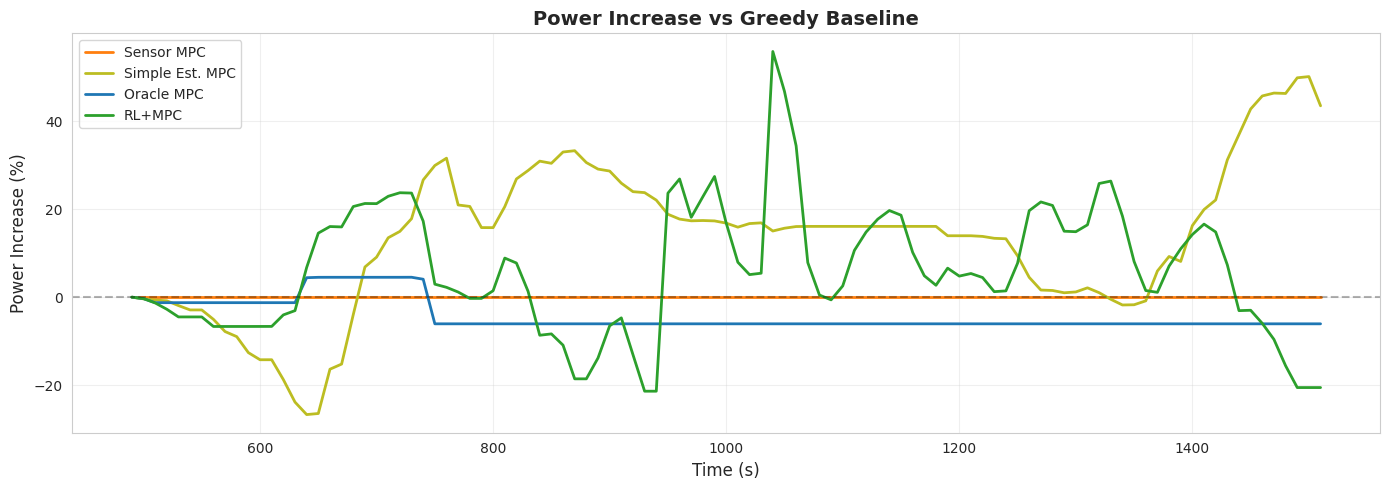

In [11]:
# Plot percentage increase over greedy baseline
if 'Greedy' in datasets:
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Get greedy power
    greedy_slice = datasets['Greedy'].sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
    greedy_power = extract_1d_timeseries(greedy_slice.powerF_a)
    greedy_time = extract_1d_timeseries(greedy_slice.time)
    
    for name, ds in datasets.items():
        if name == 'Greedy':
            continue
        
        try:
            data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
            power = extract_1d_timeseries(data_slice.powerF_a)
            time = extract_1d_timeseries(data_slice.time)
            
            # Match lengths
            min_len = min(len(power), len(greedy_power))
            pct_inc = ((power[:min_len] - greedy_power[:min_len]) / greedy_power[:min_len]) * 100
            
            ax.plot(time[:min_len], pct_inc, label=name, color=colors.get(name), linewidth=2)
        except Exception as e:
            print(f"Warning: Could not plot {name}: {e}")
    
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Power Increase (%)', fontsize=12)
    ax.set_title(f'Power Increase vs Greedy Baseline', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Individual Turbine Analysis

### 4.1 Per-Turbine Power

Found 103 turbines


ValueError: x and y must have same first dimension, but have shapes (103,) and (309,)

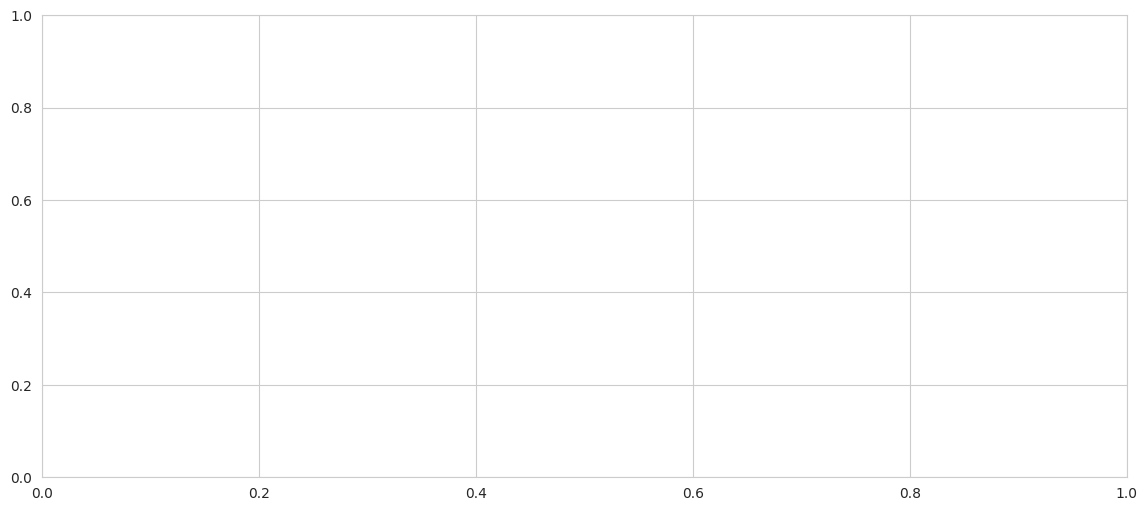

In [12]:
# Select which method to analyze
method_to_analyze = 'RL+MPC'  # Change this to analyze different methods

if method_to_analyze in datasets:
    ds = datasets[method_to_analyze]
    data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
    
    # Check if we have per-turbine power data
    if 'powerT_a' in ds.data_vars:
        # Get number of turbines
        powerT = data_slice.powerT_a
        n_turbines = powerT.shape[-1] if 'turbine' in powerT.dims else powerT.shape[0]
        
        print(f"Found {n_turbines} turbines")
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Extract time
        time = extract_1d_timeseries(data_slice.time)
        
        # Plot each turbine
        for i in range(n_turbines):
            # Handle different possible dimension structures
            if 'turbine' in powerT.dims:
                turb_power = powerT.isel(turbine=i)
            else:
                turb_power = powerT[..., i]
            
            power_1d = extract_1d_timeseries(turb_power)
            ax.plot(time[:len(power_1d)], power_1d / 1e6, label=f'Turbine {i}', linewidth=1.5)
        
        ax.set_xlabel('Time (s)', fontsize=12)
        ax.set_ylabel('Power (MW)', fontsize=12)
        ax.set_title(f'Per-Turbine Power: {method_to_analyze}', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=9, ncol=2)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No per-turbine power data (powerT_a) found in {method_to_analyze}")
else:
    print(f"{method_to_analyze} not found in datasets")

## 5. Wind Estimation Analysis

### 5.1 Wind Direction Estimation

ValueError: x and y must have same first dimension, but have shapes (103,) and (309,)

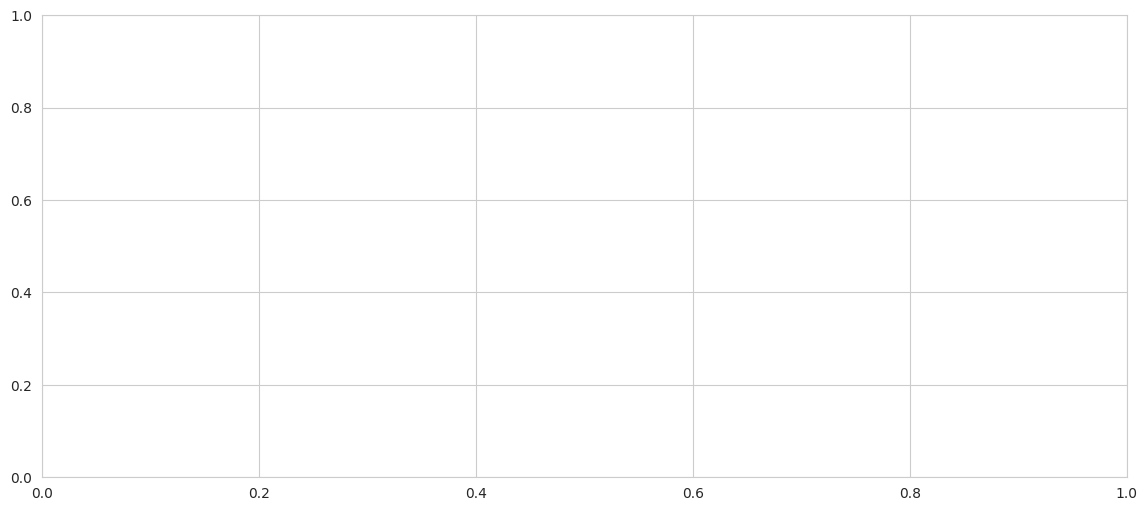

In [13]:
# Plot yaw angles for selected method
method_to_analyze = 'RL+MPC'  # Change this to analyze different methods

if method_to_analyze in datasets:
    ds = datasets[method_to_analyze]
    data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
    
    if 'yaw_a' in ds.data_vars:
        yaw_data = data_slice.yaw_a
        n_turbines = yaw_data.shape[-1] if 'turbine' in yaw_data.dims else yaw_data.shape[0]
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        time = extract_1d_timeseries(data_slice.time)
        
        # Plot each turbine's yaw angle
        for i in range(n_turbines):
            if 'turbine' in yaw_data.dims:
                turb_yaw = yaw_data.isel(turbine=i)
            else:
                turb_yaw = yaw_data[..., i]
            
            yaw_1d = extract_1d_timeseries(turb_yaw)
            ax.plot(time[:len(yaw_1d)], yaw_1d, label=f'Turbine {i}', linewidth=1.5)
        
        ax.set_xlabel('Time (s)', fontsize=12)
        ax.set_ylabel('Yaw Angle (°)', fontsize=12)
        ax.set_title(f'Turbine Yaw Angles: {method_to_analyze}', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=9, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No yaw angle data (yaw_a) found in {method_to_analyze}")
else:
    print(f"{method_to_analyze} not found in datasets")

### 4.3 Compare Yaw Angles Across Methods

/tmp/ipykernel_1874702/635241493.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=10)


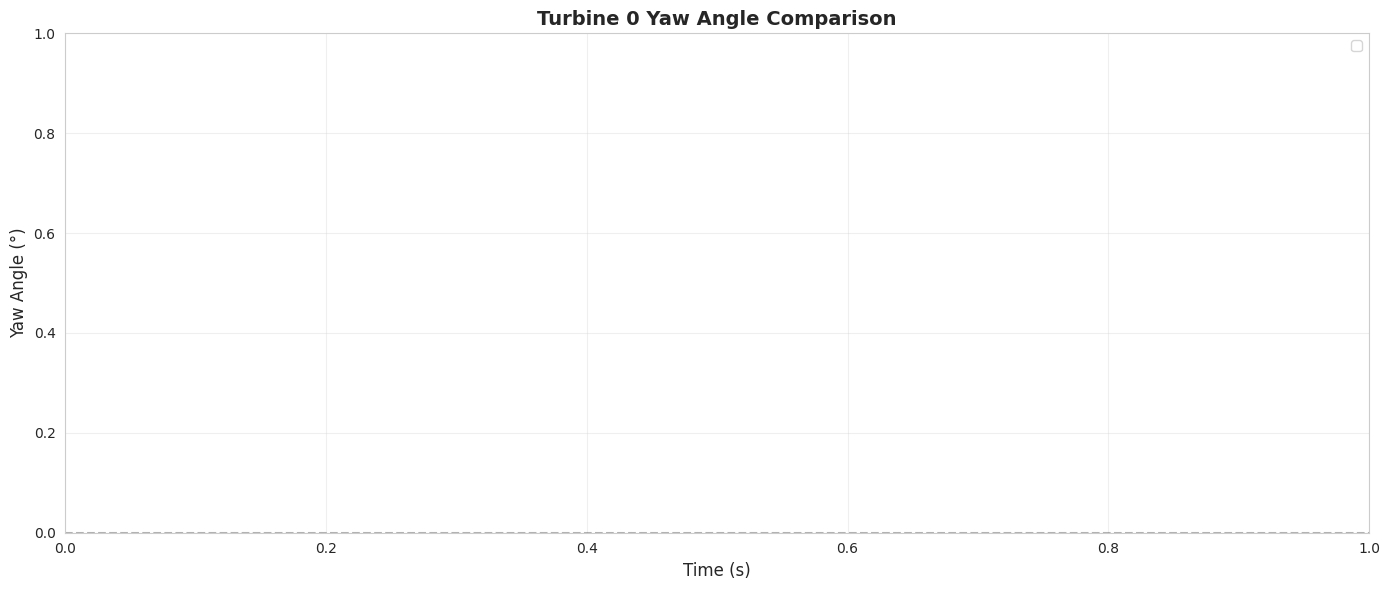

In [14]:
# Compare yaw angles for a specific turbine across all methods
turbine_idx = 0  # Change this to look at different turbines

fig, ax = plt.subplots(figsize=(14, 6))

for name, ds in datasets.items():
    if 'yaw_a' not in ds.data_vars:
        continue
    
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        yaw_data = data_slice.yaw_a
        
        # Extract yaw for specific turbine
        if 'turbine' in yaw_data.dims:
            turb_yaw = yaw_data.isel(turbine=turbine_idx)
        else:
            turb_yaw = yaw_data[..., turbine_idx]
        
        yaw_1d = extract_1d_timeseries(turb_yaw)
        time = extract_1d_timeseries(data_slice.time)
        
        ax.plot(time[:len(yaw_1d)], yaw_1d, label=name, color=colors.get(name), linewidth=2)
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Yaw Angle (°)', fontsize=12)
ax.set_title(f'Turbine {turbine_idx} Yaw Angle Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Wind Estimation Analysis

### 5.1 Wind Direction Estimation

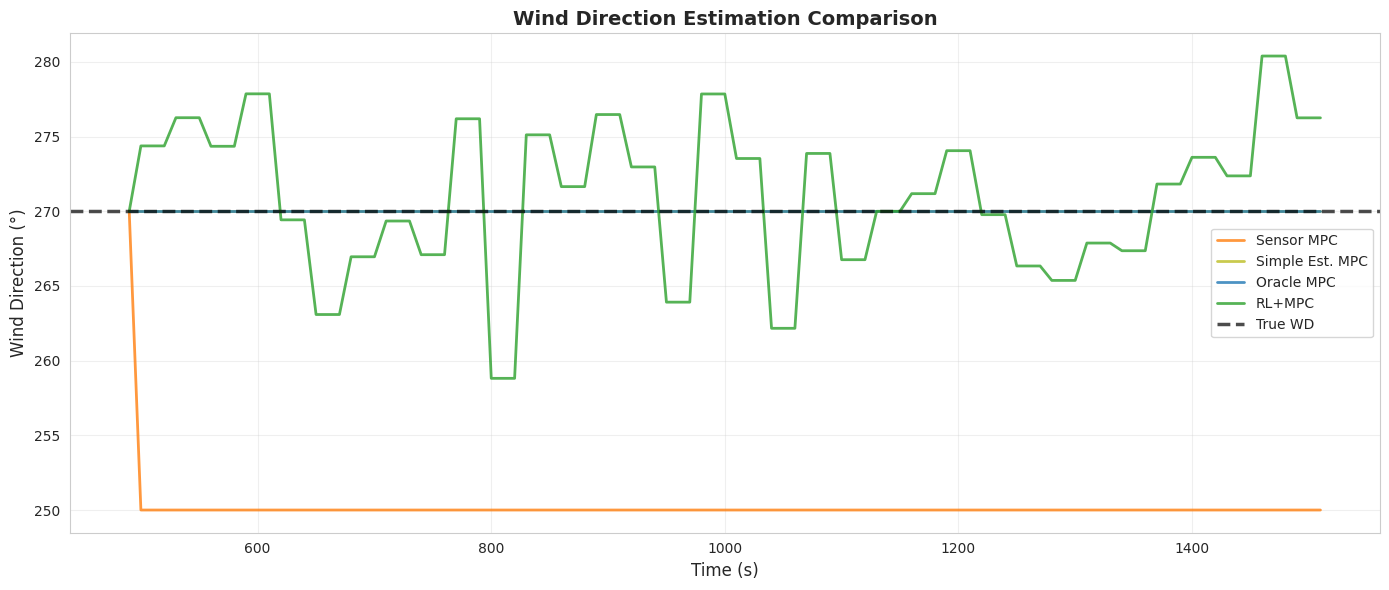

In [15]:
# Plot wind direction estimates
fig, ax = plt.subplots(figsize=(14, 6))

for name, ds in datasets.items():
    if 'estimated_wd' not in ds.data_vars:
        continue
    
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        est_wd = extract_1d_timeseries(data_slice.estimated_wd)
        time = extract_1d_timeseries(data_slice.time)
        
        ax.plot(time, est_wd, label=name, color=colors.get(name), linewidth=2, alpha=0.8)
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

# Plot true wind direction
ax.axhline(y=wd_select, color='k', linestyle='--', linewidth=2.5, label='True WD', alpha=0.7)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Wind Direction (°)', fontsize=12)
ax.set_title('Wind Direction Estimation Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2 Wind Direction Estimation Error

Sensor MPC           - RMSE: 19.903°, Bias: -19.806°
Simple Est. MPC      - RMSE: 0.000°, Bias: 0.000°
Oracle MPC           - RMSE: 0.000°, Bias: 0.000°
RL+MPC               - RMSE: 5.064°, Bias: 1.008°


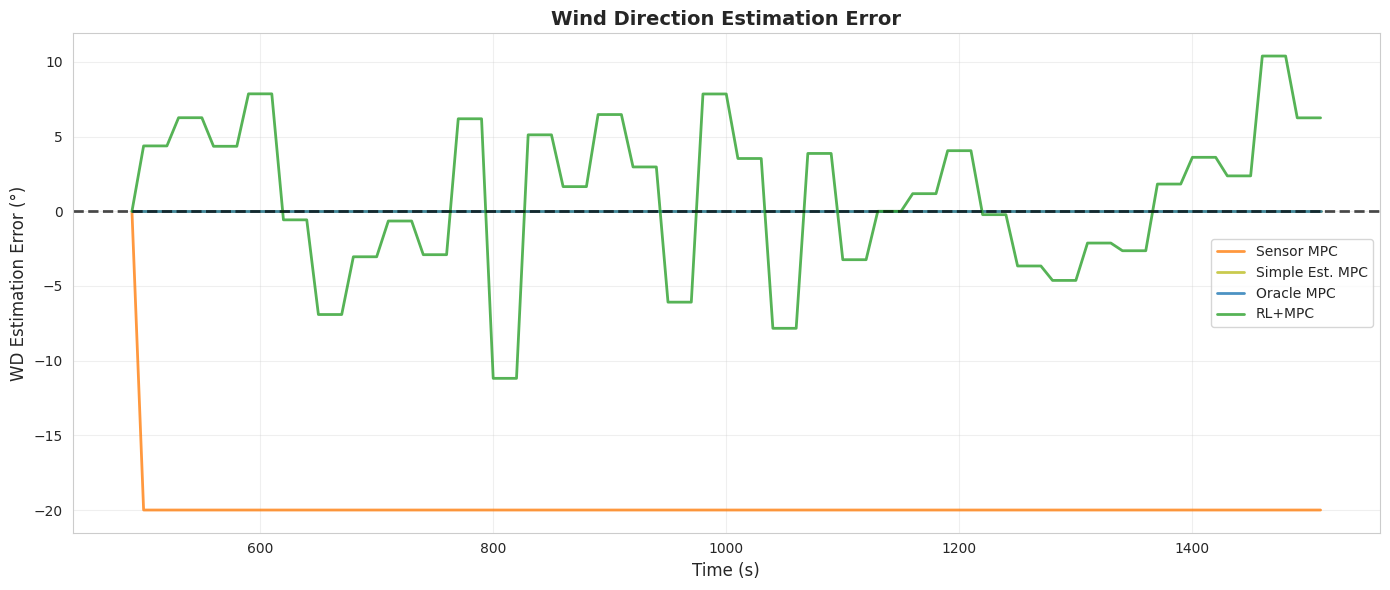

In [16]:
# Plot wind direction estimation error
fig, ax = plt.subplots(figsize=(14, 6))

for name, ds in datasets.items():
    if 'estimated_wd' not in ds.data_vars:
        continue
    
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        est_wd = extract_1d_timeseries(data_slice.estimated_wd)
        time = extract_1d_timeseries(data_slice.time)
        
        # Calculate error
        error = est_wd - wd_select
        
        ax.plot(time, error, label=name, color=colors.get(name), linewidth=2, alpha=0.8)
        
        # Print statistics
        rmse = np.sqrt(np.mean(error**2))
        bias = np.mean(error)
        print(f"{name:20s} - RMSE: {rmse:.3f}°, Bias: {bias:.3f}°")
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

ax.axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('WD Estimation Error (°)', fontsize=12)
ax.set_title('Wind Direction Estimation Error', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Performance Comparison

### 6.1 Mean Power Comparison

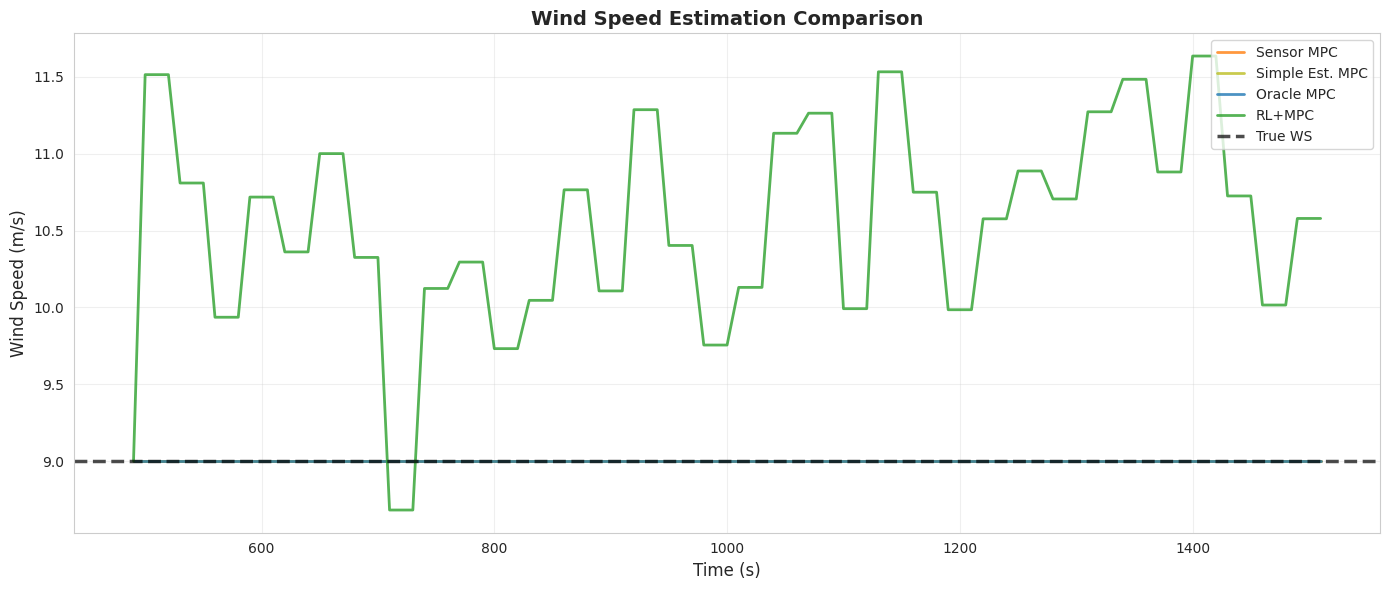

In [17]:
# Plot wind speed estimates
fig, ax = plt.subplots(figsize=(14, 6))

for name, ds in datasets.items():
    if 'estimated_ws' not in ds.data_vars:
        continue
    
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        est_ws = extract_1d_timeseries(data_slice.estimated_ws)
        time = extract_1d_timeseries(data_slice.time)
        
        ax.plot(time, est_ws, label=name, color=colors.get(name), linewidth=2, alpha=0.8)
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

# Plot true wind speed
ax.axhline(y=ws_select, color='k', linestyle='--', linewidth=2.5, label='True WS', alpha=0.7)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Wind Speed (m/s)', fontsize=12)
ax.set_title('Wind Speed Estimation Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 Turbulence Intensity Estimation

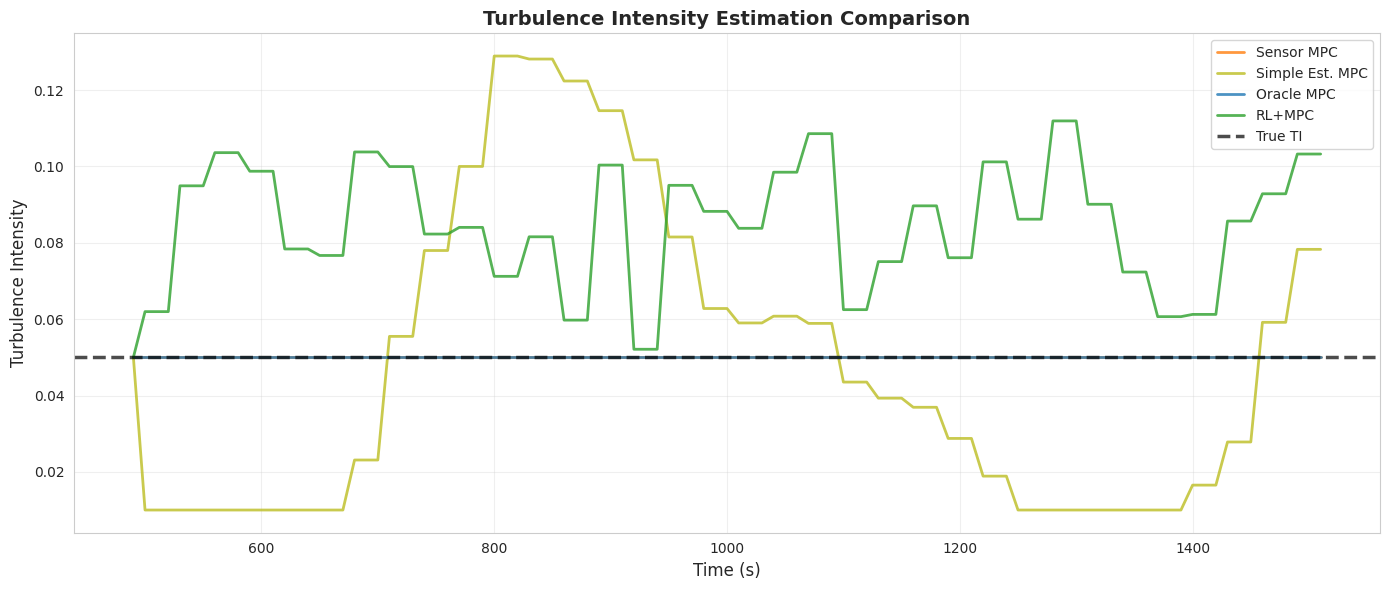

In [18]:
# Plot turbulence intensity estimates
fig, ax = plt.subplots(figsize=(14, 6))

for name, ds in datasets.items():
    if 'estimated_ti' not in ds.data_vars:
        continue
    
    try:
        data_slice = ds.sel(ws=ws_select, wd=wd_select, TI=ti_select, method='nearest')
        est_ti = extract_1d_timeseries(data_slice.estimated_ti)
        time = extract_1d_timeseries(data_slice.time)
        
        ax.plot(time, est_ti, label=name, color=colors.get(name), linewidth=2, alpha=0.8)
    except Exception as e:
        print(f"Warning: Could not plot {name}: {e}")

# Plot true TI
ax.axhline(y=ti_select, color='k', linestyle='--', linewidth=2.5, label='True TI', alpha=0.7)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Turbulence Intensity', fontsize=12)
ax.set_title('Turbulence Intensity Estimation Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Performance Comparison

### 6.1 Mean Power Comparison

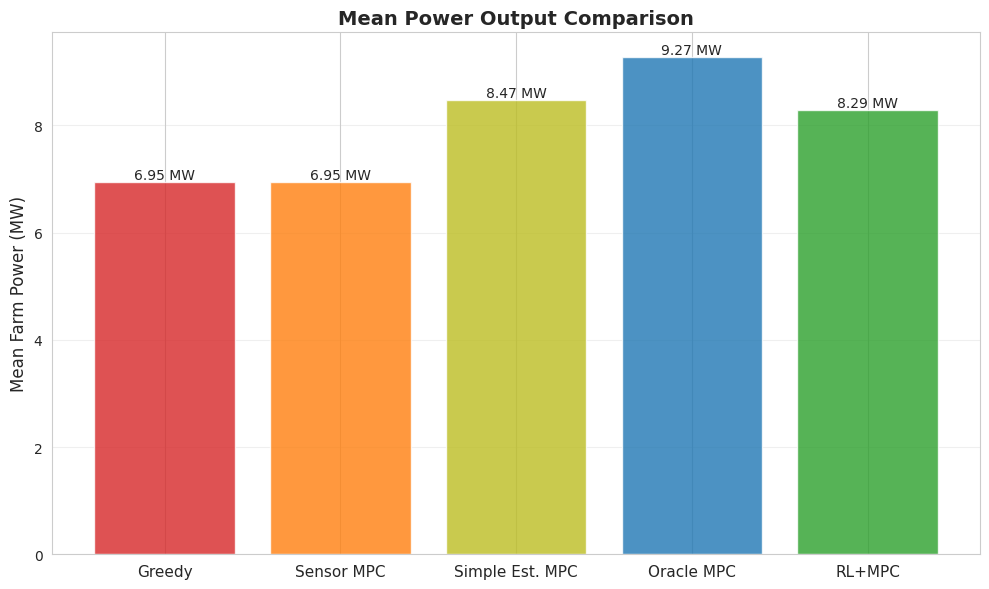

In [19]:
# Bar chart of mean power
fig, ax = plt.subplots(figsize=(10, 6))

methods = []
mean_powers = []
colors_list = []

for name, ds in datasets.items():
    methods.append(name)
    mean_powers.append(ds.powerF_a.mean().values / 1e6)
    colors_list.append(colors.get(name, '#999999'))

x_pos = np.arange(len(methods))
bars = ax.bar(x_pos, mean_powers, color=colors_list, alpha=0.8)

# Add value labels on bars
for bar, val in zip(bars, mean_powers):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:.2f} MW', ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Mean Farm Power (MW)', fontsize=12)
ax.set_title('Mean Power Output Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(methods, fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Custom Analysis

Use the cells below for your own custom explorations!

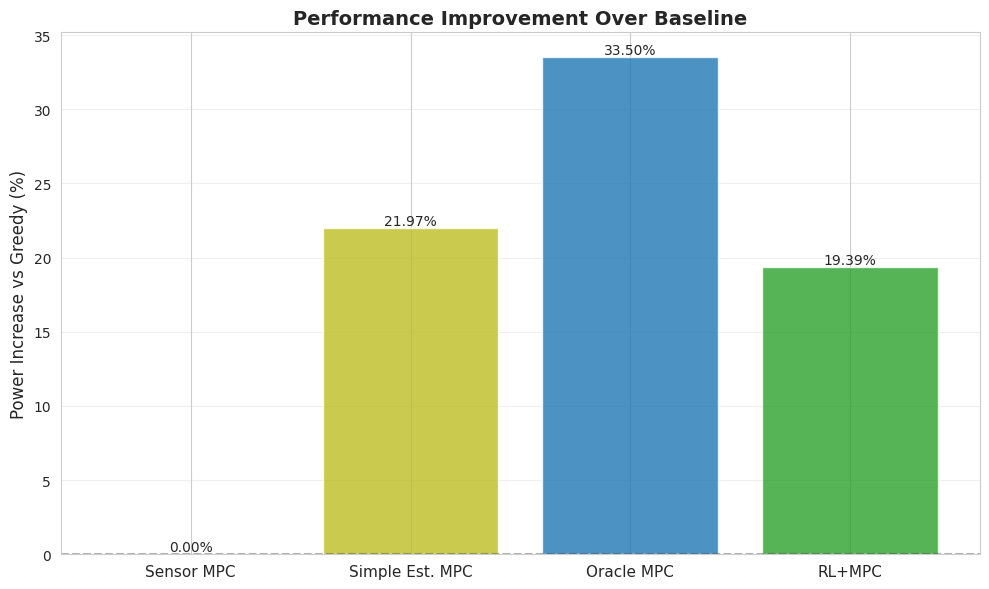

In [20]:
# Bar chart of power increase
if 'Greedy' in datasets:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    greedy_power = datasets['Greedy'].powerF_a.mean().values
    
    methods = []
    pct_increases = []
    colors_list = []
    
    for name, ds in datasets.items():
        if name == 'Greedy':
            continue
        
        power = ds.powerF_a.mean().values
        pct_inc = ((power - greedy_power) / greedy_power) * 100
        
        methods.append(name)
        pct_increases.append(pct_inc)
        colors_list.append(colors.get(name, '#999999'))
    
    x_pos = np.arange(len(methods))
    bars = ax.bar(x_pos, pct_increases, color=colors_list, alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, pct_increases):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.2f}%', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Power Increase vs Greedy (%)', fontsize=12)
    ax.set_title('Performance Improvement Over Baseline', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods, fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

### 6.3 Estimation Accuracy Summary

In [21]:
# Create summary table of estimation errors
estimation_summary = []

for name, ds in datasets.items():
    if 'estimated_wd' not in ds.data_vars:
        continue
    
    try:
        # Get all data (average over all conditions)
        est_wd = ds.estimated_wd.values.flatten()
        est_ws = ds.estimated_ws.values.flatten() if 'estimated_ws' in ds.data_vars else None
        est_ti = ds.estimated_ti.values.flatten() if 'estimated_ti' in ds.data_vars else None
        
        # Get true values
        true_wd = np.tile(ds.wd.values, len(ds.time))
        true_ws = np.tile(ds.ws.values, len(ds.time))
        true_ti = np.tile(ds.TI.values, len(ds.time))
        
        # Calculate RMSE for WD
        mask_wd = ~np.isnan(est_wd)
        true_wd_matched = np.repeat(true_wd, sum(mask_wd) // len(true_wd))[:sum(mask_wd)]
        wd_rmse = np.sqrt(np.mean((est_wd[mask_wd] - true_wd_matched)**2))
        
        # Calculate RMSE for WS
        ws_rmse = None
        if est_ws is not None:
            mask_ws = ~np.isnan(est_ws)
            true_ws_matched = np.repeat(true_ws, sum(mask_ws) // len(true_ws))[:sum(mask_ws)]
            ws_rmse = np.sqrt(np.mean((est_ws[mask_ws] - true_ws_matched)**2))
        
        # Calculate RMSE for TI
        ti_rmse = None
        if est_ti is not None:
            mask_ti = ~np.isnan(est_ti)
            true_ti_matched = np.repeat(true_ti, sum(mask_ti) // len(true_ti))[:sum(mask_ti)]
            ti_rmse = np.sqrt(np.mean((est_ti[mask_ti] - true_ti_matched)**2))
        
        estimation_summary.append({
            'Method': name,
            'WD RMSE (°)': f'{wd_rmse:.3f}',
            'WS RMSE (m/s)': f'{ws_rmse:.3f}' if ws_rmse is not None else 'N/A',
            'TI RMSE': f'{ti_rmse:.4f}' if ti_rmse is not None else 'N/A',
        })
    except Exception as e:
        print(f"Warning: Could not compute stats for {name}: {e}")

if estimation_summary:
    est_df = pd.DataFrame(estimation_summary)
    print("\n" + "="*70)
    print("ESTIMATION ACCURACY SUMMARY")
    print("="*70)
    print(est_df.to_string(index=False))
    print("="*70)


ESTIMATION ACCURACY SUMMARY
         Method WD RMSE (°) WS RMSE (m/s) TI RMSE
     Sensor MPC      20.313         0.000  0.0000
Simple Est. MPC       0.000         0.000  0.0354
     Oracle MPC       0.000         0.000  0.0000
         RL+MPC       7.609         2.394  0.0448


## 7. Custom Analysis

Use the cells below for your own custom explorations!

In [22]:
# Your custom analysis here
# Example: Compare RL+MPC vs Oracle MPC performance gap

if 'RL+MPC' in datasets and 'Oracle MPC' in datasets:
    rl_power = datasets['RL+MPC'].powerF_a.mean().values
    oracle_power = datasets['Oracle MPC'].powerF_a.mean().values
    greedy_power = datasets['Greedy'].powerF_a.mean().values if 'Greedy' in datasets else 0
    
    # Gap between RL and Oracle as percentage of total improvement potential
    rl_improvement = rl_power - greedy_power
    oracle_improvement = oracle_power - greedy_power
    
    if oracle_improvement > 0:
        gap_percentage = (rl_improvement / oracle_improvement) * 100
        print(f"\nRL+MPC captures {gap_percentage:.1f}% of the Oracle MPC improvement potential")
        print(f"Remaining gap to close: {100-gap_percentage:.1f}%")


RL+MPC captures 57.9% of the Oracle MPC improvement potential
Remaining gap to close: 42.1%


In [ ]:
# More custom analysis space


In [ ]:
# Explore dataset structure
# Uncomment to explore what's available in your datasets

# for name, ds in datasets.items():
#     print(f"\n{'='*70}")
#     print(f"Dataset: {name}")
#     print(f"{'='*70}")
#     print(ds)